In [1]:
import awkward as ak
import torch
import numpy as np
import vector
import tqdm

from torch import nn
from torch.utils.data import Dataset
import torch.nn.functional as F

import sklearn
import sklearn.metrics
import matplotlib
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cpu")
cls_loss = nn.CrossEntropyLoss(reduction="none")
reg_loss = nn.L1Loss(reduction="none")
dm_loss = nn.CrossEntropyLoss(reduction="none")

In [3]:
def med_iqr(arr):
    if len(arr) > 0:
        p25 = np.percentile(arr, 25)
        p50 = np.percentile(arr, 50)
        p75 = np.percentile(arr, 75)
    else:
        p25 = 0.0
        p50 = 0.0
        p75 = 0.0
    return p50, p75 - p25

def to_p4(p4_obj):
    if "tau" in p4_obj.fields:
        return vector.awk(
            ak.zip(
                {
                    "mass": p4_obj.tau,
                    "px": p4_obj.x,
                    "py": p4_obj.y,
                    "pz": p4_obj.z,
                }
            )
        )
    elif "t" in p4_obj.fields:
        return vector.awk(
            ak.zip(
                {
                    "energy": p4_obj.t,
                    "px": p4_obj.x,
                    "py": p4_obj.y,
                    "pz": p4_obj.z,
                }
            )
        )
    else:
        raise Exception("Unknown fields: {}".format(p4_obj.fields))

In [4]:
d = ak.from_parquet("/home/norman/ml-tau-en-reg/enreg/data/zh.parquet")

In [7]:
d['gen_jet_tau_decaymode'] != -1

<Array [True, True, True, True, ..., True, True, True] type='530722 * bool'>

In [9]:
torch.nn.functional?

Type:        module
String form: <module 'torch.nn.functional' from '/opt/conda/lib/python3.10/site-packages/torch/nn/functional.py'>
File:        /opt/conda/lib/python3.10/site-packages/torch/nn/functional.py
Docstring:   Functional interface.

In [5]:
#stores the observables and targets for either one jet, or a batch of jets
class Jet:
    def __init__(
        self,
        pfs: torch.Tensor,
        pfs_mask: torch.Tensor,
        reco_jet_pt: torch.Tensor,
        gen_tau_label: torch.Tensor,
        gen_tau_pt: torch.Tensor
    ):
        self.pfs = pfs
        self.pfs_mask = pfs_mask
        self.reco_jet_pt = reco_jet_pt
        self.gen_tau_label = gen_tau_label
        self.gen_tau_pt = gen_tau_pt
        
class TauDataset(Dataset):
    def __init__(self, filenames):
        datas = []

        #load all files, concatenate, shuffle
        for fn in filenames:
            d = ak.from_parquet(fn)
            datas.append(d)
        data_all = ak.concatenate(datas, axis=0)
        sort_idx = np.random.permutation(len(data_all))
        data_all = data_all[sort_idx]

        #per-jet PF candidates
        pf_p4s = to_p4(data_all["reco_cand_p4s"])

        #indices to map each PF candidate to jet 
        self.pf_lengths = ak.to_numpy(ak.num(pf_p4s))
        self.pf_startidx = np.cumsum(self.pf_lengths)
        self.pf_startidx -= self.pf_lengths

        #per PF candidate observables
        self.pf_pt = torch.unsqueeze(torch.tensor(ak.to_numpy(ak.flatten(pf_p4s.pt))), axis=-1).to(torch.float32)
        self.pf_eta = torch.unsqueeze(torch.tensor(ak.to_numpy(ak.flatten(pf_p4s.eta))), axis=-1).to(torch.float32)
        self.pf_phi = torch.unsqueeze(torch.tensor(ak.to_numpy(ak.flatten(pf_p4s.phi))), axis=-1).to(torch.float32)
        self.pf_energy = torch.unsqueeze(torch.tensor(ak.to_numpy(ak.flatten(pf_p4s.energy))), axis=-1).to(torch.float32)
        self.pf_pdg = torch.unsqueeze(torch.tensor(ak.to_numpy(ak.flatten(np.abs(data_all["reco_cand_pdg"])))), axis=-1).to(torch.float32)
        self.pf_charge = torch.unsqueeze(torch.tensor(ak.to_numpy(ak.flatten(data_all["reco_cand_charge"]))), axis=-1).to(torch.float32)

        #per-jet observables
        reco_jet_p4s = to_p4(data_all["reco_jet_p4s"])
        self.reco_jet_pts = torch.unsqueeze(torch.tensor(ak.to_numpy(reco_jet_p4s.pt)), axis=-1).to(torch.float32)

        #per-jet targets
        gen_jet_p4s = to_p4(data_all["gen_jet_tau_p4s"])
        print(gen_jet_p4s.fields)
        self.gen_tau_labels = torch.unsqueeze(torch.tensor(ak.to_numpy(data_all["gen_jet_tau_decaymode"])), axis=-1).to(torch.float32)
        self.gen_tau_pts = torch.unsqueeze(torch.tensor(ak.to_numpy(gen_jet_p4s.pt)), axis=-1).to(torch.float32)

    def __len__(self):
        return len(self.pf_lengths)

    def __getitem__(self, idx):
        assert(isinstance(idx, int))

        #get the indices of the PF candidates of the jet at 'idx'
        pf_range = range(self.pf_startidx[idx], self.pf_startidx[idx] + self.pf_lengths[idx])
        pf_pt = self.pf_pt[pf_range]
        pf_eta = self.pf_eta[pf_range]
        pf_phi = self.pf_phi[pf_range]
        pf_energy = self.pf_energy[pf_range]
        pf_pdg = self.pf_pdg[pf_range] #FIXME: this could be better as a one-hot encoded value, rather than a floating-point PDGID value
        pf_charge = self.pf_charge[pf_range]
        pfs = torch.concatenate([pf_pt, pf_eta, torch.sin(pf_phi), torch.cos(pf_phi), pf_energy, pf_pdg, pf_charge], axis=-1)
        
        return Jet(
            pfs=pfs,
            pfs_mask=torch.ones(pfs.shape[0], dtype=torch.float32),
            reco_jet_pt=self.reco_jet_pts[idx],
            gen_tau_label=self.gen_tau_labels[idx],
            gen_tau_pt=self.gen_tau_pts[idx]
        )
        
#given multiple jets with a variable number of PF candidates per jet, create 3d-padded arrays
#in the shape [Njets, Npfs_max, Nfeat]
def pad_collate(jets):
    pfs = [jet.pfs for jet in jets]
    pfs_mask = [jet.pfs_mask for jet in jets]
    gen_tau_label = [jet.gen_tau_label for jet in jets]
    gen_tau_pt = [jet.gen_tau_pt for jet in jets]
    reco_jet_pt = [jet.reco_jet_pt for jet in jets]
    
    pfs = torch.nn.utils.rnn.pad_sequence(pfs, batch_first=True)
    pfs_mask = torch.nn.utils.rnn.pad_sequence(pfs_mask, batch_first=True)
    gen_tau_label = torch.concatenate(gen_tau_label, axis=0)
    gen_tau_pt = torch.concatenate(gen_tau_pt, axis=0)
    reco_jet_pt = torch.concatenate(reco_jet_pt, axis=0)
    
    return Jet(
        pfs=pfs,
        pfs_mask=pfs_mask,
        reco_jet_pt=reco_jet_pt,
        gen_tau_label=gen_tau_label,
        gen_tau_pt=gen_tau_pt
    )

In [6]:
loader_kwargs = {
    "batch_size": 2048,
    "collate_fn": pad_collate,
    "num_workers": 8,
    "prefetch_factor": 20,
    # "pin_memory": True,
    # "pin_memory_device": "cuda",
}

In [7]:
d1 = ak.from_parquet("/home/norman/ml-tau-en-reg/enreg/data/qq.parquet")
d1["gen_jet_tau_p4s"].fields

['x', 'y', 'z', 'tau']

In [8]:
d2 = ak.from_parquet("/home/norman/ml-tau-en-reg/enreg/data/z.parquet")
d2["gen_jet_tau_p4s"].fields

['x', 'y', 'z', 'tau']

In [9]:
d3 = ak.from_parquet("/home/norman/ml-tau-en-reg/enreg/data/zh.parquet")
d3["gen_jet_tau_p4s"].fields

['x', 'y', 'z', 'tau']

In [10]:
#for training the tau classifier, use tau and non-tau datasets
ds_sig_and_bkg = TauDataset(["/home/norman/ml-tau-en-reg/enreg/data/qq.parquet", "/home/norman/ml-tau-en-reg/enreg/data/z.parquet"])
# ds_sig_and_bkg = torch.utils.data.Subset(ds_sig_and_bkg, range(200000))
ds_train, ds_val = torch.utils.data.random_split(ds_sig_and_bkg, [0.6, 0.4])

dl_sig_and_bkg_train = torch.utils.data.DataLoader(ds_train, **loader_kwargs)
dl_sig_and_bkg_val = torch.utils.data.DataLoader(ds_val, **loader_kwargs)

['x', 'y', 'z', 'tau']


In [11]:
#for training tau pt regression and decay mode, only use the tau dataset
ds_sig = TauDataset(["/home/norman/ml-tau-en-reg/enreg/data/z.parquet", "/home/norman/ml-tau-en-reg/enreg/data/zh.parquet"])
# ds_sig = torch.utils.data.Subset(ds_sig, range(200000))
ds_train, ds_val = torch.utils.data.random_split(ds_sig_and_bkg, [0.6, 0.4])

dl_sig_train = torch.utils.data.DataLoader(ds_train, **loader_kwargs)
dl_sig_val = torch.utils.data.DataLoader(ds_val, **loader_kwargs)

['x', 'y', 'z', 'tau']


In [12]:
def ffn(input_dim, output_dim, width, act, dropout):
    return nn.Sequential(
        nn.Linear(input_dim, width),
        act(),
        nn.Dropout(dropout),
        nn.Linear(width, width),
        act(),
        nn.Dropout(dropout),
        nn.Linear(width, width),
        act(),
        nn.Dropout(dropout),
        nn.Linear(width, output_dim),
    )
    
class DeepSet(nn.Module):
    def __init__(self, num_outputs):
        super(DeepSet, self).__init__()

        self.act = nn.ReLU
        self.act_obj = self.act()
        self.dropout = 0.1
        self.width = 64
        self.embedding_dim = 64

        #number of inputs
        self.num_pf_features = 7

        self.nn_pf_embedding = ffn(self.num_pf_features, self.embedding_dim, self.width, self.act, self.dropout)
        self.nn_pred = ffn(self.embedding_dim, num_outputs, self.width, self.act, self.dropout)

    def forward(self, pfs_pad, pfs_mask):
        pfs_mask = torch.unsqueeze(pfs_mask, axis=-1)
        pf_encoded = self.act_obj(self.nn_pf_embedding(pfs_pad))*pfs_mask
        num_pfs = torch.sum(pfs_mask, axis=1)
        jet_encoded1 = self.act_obj(torch.sum(pf_encoded, axis=1)/num_pfs)
        ret = self.nn_pred(jet_encoded1)
        return ret

In [59]:
def model_loop(model, optimizer, ds_loader, dev, is_train=True, kind="binary"):
    loss_tot = 0.0
    pred_vals = []
    true_vals = []
    for ibatch, batched_jets in enumerate(tqdm.tqdm(ds_loader, total=len(ds_loader), ncols=80)):
        
        pfs = batched_jets.pfs.to(dev, non_blocking=True)
        pfs_mask = batched_jets.pfs_mask.to(dev, non_blocking=True)
        gen_tau_label = batched_jets.gen_tau_label.to(dev, non_blocking=True)
        true_istau = gen_tau_label!=-1

        pred = model(pfs, pfs_mask)

        if kind == "binary":
            assert(pred.shape[1] == 2)
            pred_vals.append(pred[:, 1].detach().cpu())
            true_vals.append(true_istau.cpu())
            loss = cls_loss(pred, true_istau.long()).mean()
        elif kind == "ptreg":
            #pred = log(ptgen/ptreco) -> ptgen = exp(pred)*ptreco
            assert(pred.shape[1] == 1)
            pred = torch.squeeze(pred, dim=-1)
            gen_tau_pt = batched_jets.gen_tau_pt.to(dev, non_blocking=True)
            reco_jet_pt = batched_jets.reco_jet_pt.to(dev, non_blocking=True)

            target = torch.log(gen_tau_pt/reco_jet_pt)
            
            pred_pt = torch.exp(pred) * reco_jet_pt
            pred_vals.append(pred_pt[gen_tau_label!=-1].detach().cpu())
            true_vals.append(gen_tau_pt[gen_tau_label!=-1].cpu())
            loss = reg_loss(pred[true_istau], target[true_istau])
            loss = torch.sum(loss) / torch.sum(true_istau)
        elif kind == "dm_multiclass":
            assert(pred.shape[1] == 16)
            pred_vals.append(torch.argmax(pred[true_istau], axis=-1).detach().cpu())
            true_vals.append(gen_tau_label[true_istau].cpu())
            target_onehot = torch.nn.functional.one_hot(gen_tau_label[true_istau].long(), 16).float()
            
            # print("target", target_onehot.shape)
            # print("target", target_onehot)
            print("pred", pred.shape)
            print("pred", pred)
            # print("-----------------")
            print(torch.argmax(pred, axis=-1))
            # print(torch.argmax(pred[true_istau], axis=-1)[0])
            # print(gen_tau_label[true_istau])
            
            loss = dm_loss(pred[true_istau], target_onehot)
            loss = torch.sum(loss) / torch.sum(true_istau)
        else:
            raise Exception("Unknown kind={}".format(kind))
            
        if is_train:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        loss_tot += loss.detach().cpu().item()
    return loss_tot, pred_vals, true_vals

In [16]:
torch.argmax?

Docstring:
argmax(input) -> LongTensor

Returns the indices of the maximum value of all elements in the :attr:`input` tensor.

This is the second value returned by :meth:`torch.max`. See its
documentation for the exact semantics of this method.

.. note:: If there are multiple maximal values then the indices of the first maximal value are returned.

Args:
    input (Tensor): the input tensor.

Example::

    >>> a = torch.randn(4, 4)
    >>> a
    tensor([[ 1.3398,  0.2663, -0.2686,  0.2450],
            [-0.7401, -0.8805, -0.3402, -1.1936],
            [ 0.4907, -1.3948, -1.0691, -0.3132],
            [-1.6092,  0.5419, -0.2993,  0.3195]])
    >>> torch.argmax(a)
    tensor(0)

.. function:: argmax(input, dim, keepdim=False) -> LongTensor
   :noindex:

Returns the indices of the maximum values of a tensor across a dimension.

This is the second value returned by :meth:`torch.max`. See its
documentation for the exact semantics of this method.

Args:
    input (Tensor): the input tensor

In [ ]:
#Train binary classification head with two outputs (tau vs. notau logits)
model_binary_classifier = DeepSet(2).to(device)
optimizer = torch.optim.AdamW(model_binary_classifier.parameters(), lr=1e-3)

losses_train = []
losses_val = []

for iepoch in range(20):
    loss_train, _, _ = model_loop(model_binary_classifier, optimizer, dl_sig_and_bkg_train, device, True, kind="binary")
    loss_val, pred_val_cls, true_val_cls = model_loop(model_binary_classifier, optimizer, dl_sig_and_bkg_val, device, False, kind="binary")
    print("{} L={:.2f}/{:.2f}".format(iepoch, loss_train, loss_val))
    losses_train.append(loss_train)
    losses_val.append(loss_val)

In [ ]:
fpr, tpr, _ = sklearn.metrics.roc_curve(torch.concatenate(true_val_cls), torch.concatenate(pred_val_cls))
plt.figure(figsize=(5,5))
plt.title("epoch={} val_loss={:.2f}".format(iepoch, loss_val))
plt.plot(tpr, fpr)
plt.yscale("log")
plt.ylim(1e-6,1)
plt.xlim(0,1)
plt.xlabel("TPR")
plt.ylabel("FPR")

In [ ]:
plt.figure()
plt.plot(losses_train, label="train")
plt.plot(losses_val, label="validation")
plt.ylim(losses_val[-1]*0.5, losses_val[-1]*4)
plt.xlabel("epoch")
plt.ylabel("loss, tau identification")
plt.legend(loc="best")

In [ ]:
#Train pt regression head, predicts one value: y=log(ptgen/ptreco)
model_ptreg = DeepSet(1).to(device)
optimizer = torch.optim.AdamW(model_ptreg.parameters(), lr=1e-3)

losses_train = []
losses_val = []

for iepoch in range(20):
    loss_train, _, _ = model_loop(model_ptreg, optimizer, dl_sig_train, device, is_train=True, kind="ptreg")
    loss_val, pred_val_reg, true_val_reg = model_loop(model_ptreg, optimizer, dl_sig_val, device, is_train=False, kind="ptreg")
    print("{} L={:.2f}/{:.2f}".format(iepoch, loss_train, loss_val))
    losses_train.append(loss_train)
    losses_val.append(loss_val)

In [ ]:
plt.figure()
plt.plot(losses_train, label="train")
plt.plot(losses_val, label="validation")
#plt.ylim(losses_val[-1]*0.8, losses_val[-1]*1.5)
plt.xlabel("epoch")
plt.ylabel("loss, pt regression")
plt.legend(loc="best")

In [ ]:
true_pts = torch.concatenate(true_val_reg)
pred_pts = torch.concatenate(pred_val_reg)
b = np.linspace(0,200,100)
plt.hist(true_pts, bins=b, histtype="step", lw=1, label="true");
plt.hist(pred_pts, bins=b, histtype="step", lw=1, label="pred");
plt.xlabel("pT")
plt.legend(loc="best")

In [ ]:
b = np.linspace(0,200,100)
plt.figure(figsize=(5,5))
plt.hist2d(true_pts, pred_pts, bins=(b,b), cmap="Blues");
plt.plot([0,200], [0,200], color="black", ls="--", lw=0.5)
plt.xlabel("true pT")
plt.ylabel("pred pT")

In [ ]:
b = np.linspace(0,200,100)
plt.figure(figsize=(5,5))
plt.hist2d(true_pts, pred_pts, bins=(b,b), cmap="Blues", norm=matplotlib.colors.LogNorm());
plt.plot([0,200], [0,200], color="black", ls="--", lw=0.5)
plt.xlabel("true pT")
plt.ylabel("pred pT")

In [ ]:
b = np.linspace(0,2,100)
plt.figure(figsize=(5,5))
ratio = pred_pts/true_pts
plt.hist(ratio, bins=b, histtype="step", lw=1);
med, iqr = med_iqr(ratio)
plt.title("M={:.2f}, IQR/M={:.2f}".format(med, iqr/med))
plt.axvline(1.0, color="black", ls="--", lw=0.5)
plt.xlabel("pred/true pT")
plt.ylabel("number of jets / bin")

In [ ]:
pred_pts[(true_pts>20) & (true_pts<30)]

In [ ]:
b = np.linspace(0,10,100)
plt.figure(figsize=(5,5))
ratio = pred_pts/true_pts
plt.hist(ratio, bins=b, histtype="step", lw=1);
plt.yscale("log")
med, iqr = med_iqr(ratio)
plt.title("M={:.2f}, IQR/M={:.2f}".format(med, iqr/med))
plt.axvline(1.0, color="black", ls="--", lw=0.5)
plt.xlabel("pred/true pT")
plt.ylabel("number of jets / bin")

In [ ]:
bins = [20,30,40,50,60,70,80,90,100,125,150,175,200]
medvals = []
meanvals = []
iqrvals = []
fig = plt.figure(figsize=(12,8))
for ibin in range(len(bins)-1):
    msk = (true_pts>bins[ibin]) & (true_pts<bins[ibin+1])
    med, iqr = med_iqr(ratio[msk])
    meanvals.append(ratio[msk].mean())
    ax1 = plt.subplot(3, 4, ibin+1)
    plt.title("bin={},{}".format(bins[ibin], bins[ibin+1]))
    plt.hist(ratio[msk], bins=np.linspace(0.5,1.5,101), histtype="step", lw=0.5, density=1, color="black")
    medvals.append(med)
    iqrvals.append(iqr/med)
plt.tight_layout()

In [ ]:
plt.figure()
plt.plot(bins[:-1], medvals, marker="o")
plt.ylabel("median of pred/true pT")
plt.axhline(1.0, color="black", ls="--")
plt.ylim(0.95,1.05)
plt.xlabel("true pT")

In [ ]:
plt.figure()
plt.plot(bins[:-1], iqrvals, marker="o")
plt.ylabel("IQR/median of pred/true pT")
plt.xlabel("true pT")
plt.ylim(0.0, 0.1)

In [60]:
#Train pt regression head, predicts one value: y=log(ptgen/ptreco)
model_dm = DeepSet(16).to(device)
optimizer = torch.optim.AdamW(model_dm.parameters(), lr=1e-3)

losses_train = []
losses_val = []

for iepoch in range(20):
    loss_train, _, _ = model_loop(model_dm, optimizer, dl_sig_train, device, is_train=True, kind="dm_multiclass")
    loss_val, pred_val_dm, true_val_dm = model_loop(model_dm, optimizer, dl_sig_val, device, is_train=False, kind="dm_multiclass")
    print("{} L={:.2f}/{:.2f}".format(iepoch, loss_train, loss_val))
    losses_train.append(loss_train)
    losses_val.append(loss_val)

  0%|                                          | 1/1167 [00:02<50:50,  2.62s/it]

pred torch.Size([2048, 16])
pred tensor([[ 0.0351, -0.2065,  0.2026,  ...,  0.0713, -0.0439, -0.0272],
        [-0.0097, -0.1422,  0.1584,  ...,  0.0242, -0.0528, -0.0526],
        [ 0.0017, -0.1560,  0.1268,  ...,  0.0235, -0.0215, -0.0631],
        ...,
        [-0.0849, -0.1639,  0.1564,  ...,  0.0175, -0.0050, -0.1179],
        [ 0.0499, -0.1587,  0.1605,  ...,  0.0879, -0.0410, -0.0129],
        [-0.0111, -0.1507,  0.1327,  ...,  0.0293, -0.0663, -0.0427]],
       grad_fn=<AddmmBackward0>)
tensor([ 2,  2,  2,  ...,  2, 11, 11])


  0%|                                          | 2/1167 [00:03<26:31,  1.37s/it]

pred torch.Size([2048, 16])
pred tensor([[-0.0322, -0.1238,  0.1523,  ...,  0.0061,  0.0257, -0.1456],
        [-0.0427, -0.0812,  0.1197,  ..., -0.0076, -0.0448, -0.1854],
        [-0.0197, -0.1014,  0.1294,  ...,  0.0091, -0.0666, -0.1692],
        ...,
        [-0.0086, -0.0493,  0.1655,  ...,  0.0021, -0.0100, -0.0564],
        [ 0.0280, -0.0543,  0.1408,  ...,  0.0148, -0.0871, -0.0623],
        [ 0.0104, -0.0874,  0.1508,  ...,  0.0077, -0.1012, -0.0920]],
       grad_fn=<AddmmBackward0>)
tensor([2, 5, 2,  ..., 2, 2, 2])


  0%|                                          | 3/1167 [00:03<16:19,  1.19it/s]

pred torch.Size([2048, 16])
pred tensor([[-0.0066, -0.0419,  0.1598,  ...,  0.0045, -0.1137, -0.1301],
        [ 0.0207, -0.0196,  0.1986,  ..., -0.0242, -0.1004, -0.1001],
        [-0.0387, -0.0668,  0.1508,  ...,  0.0540, -0.0353, -0.1040],
        ...,
        [ 0.0835, -0.0506,  0.1541,  ...,  0.0072, -0.1580, -0.0860],
        [ 0.0603, -0.0479,  0.2256,  ...,  0.0353, -0.0743, -0.0921],
        [ 0.0122, -0.0270,  0.2125,  ..., -0.0128, -0.0988, -0.1693]],
       grad_fn=<AddmmBackward0>)
tensor([2, 2, 2,  ..., 2, 2, 2])


  0%|▏                                         | 4/1167 [00:03<12:05,  1.60it/s]

pred torch.Size([2048, 16])
pred tensor([[ 0.0519, -0.0320,  0.1547,  ..., -0.0007, -0.0538, -0.1894],
        [ 0.0522, -0.0355,  0.2177,  ..., -0.0155, -0.0637, -0.1615],
        [ 0.0222,  0.0224,  0.2269,  ...,  0.0694, -0.0795, -0.1351],
        ...,
        [-0.0126, -0.0301,  0.1819,  ...,  0.0502, -0.1261, -0.1538],
        [ 0.0175,  0.0438,  0.2075,  ...,  0.0121, -0.1162, -0.0779],
        [-0.0063, -0.0550,  0.2155,  ..., -0.0810, -0.0707, -0.1454]],
       grad_fn=<AddmmBackward0>)
tensor([ 2,  2,  2,  ..., 10,  2,  2])


  0%|▏                                         | 4/1167 [00:04<19:59,  1.03s/it]


KeyboardInterrupt: 

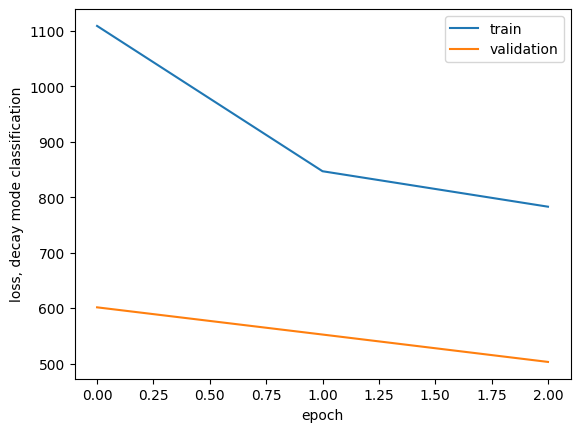

In [15]:
plt.figure()
plt.plot(losses_train, label="train")
plt.plot(losses_val, label="validation")
#plt.ylim(losses_val[-1]*0.5, losses_val[-1]*1.5)
plt.xlabel("epoch")
plt.ylabel("loss, decay mode classification")
plt.legend(loc="best")